In [67]:
#!pip install tkiner

In [ ]:
#!conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [86]:
# torch.__version__
# '1.8.1+cu102'

## Распознавание цифр на изображении

In [11]:
# trkinter для создания формы
from tkinter import *
from tkinter import filedialog
from PIL import ImageTk, Image
from functools import partial

# для создания и обучения нейросети
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

# cv2 для обратки изображений и распознавания объектов
import os
import cv2
import numpy as np
import imutils

In [12]:
cv2.__version__

'4.5.1'

In [3]:
imutils.__version__

'0.5.4'

In [5]:
# задаем все необходимые параметры
# создаем переменные необходимые для обучения и тестирования нейросети
n_epochs = 10 # количество эпох обучения
batch_size_train = 64 # размер батча на обучающей выборке
batch_size_test = 1000 # размер батча на тестовой выборке
learning_rate = 0.01 # шаг обучения
momentum = 0.5
log_interval = 100 

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [6]:
# загружаем датасет MNIST

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [10]:
example_data.shape

torch.Size([1000, 1, 28, 28])

Посмотрим как выглядит один тестовый батч.

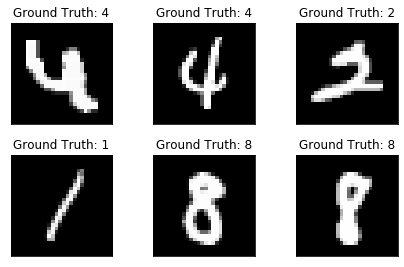

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

Создадим простую сеть из двух convolution слоев + MaxPooling + ReLU, слоя dropout и 2 fully-connected слоев. В качестве функции активации на последнем слое используем SoftMax.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2)
        
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.pool2 = nn.MaxPool2d(2)
        
        self.relu2 = nn.ReLU()
        
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        conv1 = self.conv1(x)
        x = self.pool1(conv1)
        x = self.relu1(x)
        
        conv2 = self.conv2(x)
        x = self.pool2(conv2)
        x = self.relu2(x)
        #x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        x = x.view(-1, 320)
        x = self.relu3(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Инициализируем сеть и оптимизатор. В качестве оптимизатора используем SGD, внутрь которого подадим параметры модели, а также learning rate, с которым сеть будет обучаться.

In [13]:
net = Net()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [14]:
# посмотрим на структуру модели
summary(net.cuda(), (1, 28, 28))

C:\Users\Dmitry\Anaconda\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
         MaxPool2d-2           [-1, 10, 12, 12]               0
              ReLU-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 8, 8]           5,020
         MaxPool2d-5             [-1, 20, 4, 4]               0
              ReLU-6             [-1, 20, 4, 4]               0
            Linear-7                   [-1, 50]          16,050
              ReLU-8                   [-1, 50]               0
            Linear-9                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.08
Estimated Total Size (MB): 0.17
---------------------------------------------

**Обучение**

In [136]:
# дополнительные массивы для вывода графика
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs)]

In [138]:
# функция для обучения модели
def train(epoch):
    net.train() # сеть переходит в режим обучения
    for batch_idx, (data, target) in enumerate(train_loader): # проходим по данным
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target) # находим ошибку между предсказанным значением и известным
        loss.backward() # метод обратного распространения ошибки
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            
    try:
        os.mkdir('results')
    except:
        pass
    torch.save(net.state_dict(), 'results/model.pth')
    torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [14]:
# функция для тестирования модели
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1] # находим индекс наибольшей вероятности принадлежности цифры к одному из классов
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Запустим обучение.

In [141]:
#net = net.to('cpu')
#for epoch in range(1, n_epochs + 1):
#    train(epoch)
#    test()

C:\Users\Dmitry\Anaconda\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322691
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.870071
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.831520
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.674736
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.275705
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.736594
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.475370
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.350001
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.334477
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.329610


C:\Users\Dmitry\Anaconda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1312, Accuracy: 9604/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.409555
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.432450
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.377096
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.439671
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.237846
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.228680
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.329572
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.228428
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.225818
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.194295

Test set: Avg. loss: 0.0876, Accuracy: 9731/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.200874
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.188618
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.210214
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.265255
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.324447
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.145656
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.190416
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.307

In [142]:
len(test_losses)

10

In [143]:
len(test_counter)

10

Посмотрим на результат обучения - выведем график ошибки.

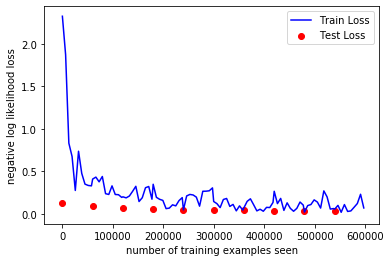

In [145]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

**Посмотрим на результат обучения - сделаем предсказание для нескольких изображений.**

C:\Users\Dmitry\Anaconda\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


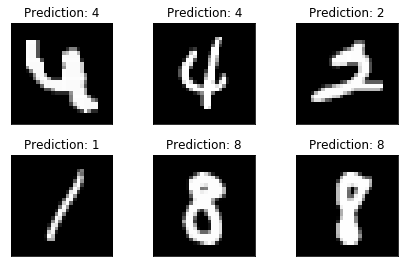

In [15]:
net = Net()
state = torch.load("results/model.pth")

net.load_state_dict(state)
net.eval()

#with torch.no_grad():
output = net(example_data)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()

# Распознавание на реальной фотографии

In [5]:
def recognize(path):

    #читаем изображение
    img = cv2.imread(path)
    img = imutils.resize(img,width=300)
    
    #преобразуем изображение из RGB в Gray 
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #создаем матрицу
    kernel = np.ones((40,40),np.uint8)

    #создаем границу, с помощью которой будем отделять цифру от всего остального
    blackhat = cv2.morphologyEx(gray,cv2.MORPH_BLACKHAT,kernel)
    ret,thresh = cv2.threshold(blackhat,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    #находим с помощью границы контуры изображения
    _,cnts,hie = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    #загружаем обученную нейросеть
    net = Net()
    state = torch.load("results/model.pth")
    net.load_state_dict(state)
    net.eval()
    
    # для каждого найденного контура цифры
    for c in cnts:
        #создаем маску
        mask = np.zeros(gray.shape,dtype="uint8")
        # получаем границы контура
        (x,y,w,h) = cv2.boundingRect(c)

        # находим многоугольник внутри которого расположена цифра
        hull = cv2.convexHull(c) 
        cv2.drawContours(mask,[hull],-1,255,-1) 
        # побитовое умножение изображения на фильтр (получаем ч/б изображение)
        mask = cv2.bitwise_and(thresh,thresh,mask=mask)

        #находим Region of interest
        roi = mask[y-7:y+h+7,x-7:x+w+7] 
        if roi.shape[0] == 0 or roi.shape[1] == 0:
            continue

        # изменяем размер изображение на 28х28
        roi = cv2.resize(roi,(28,28))
        roi = np.array(roi)
        #изменяем размер матрицы до того размера, который может принять модель
        roi = torch.Tensor(roi)

        #делаем предсказание
        prediction = net(roi.reshape(1,1,28,28)).detach().numpy()

        # рисуем область изображения (зеленый прямоугольник) и рисуем цифру
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
        cv2.putText(img,str(int(np.argmax(prediction))),(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,0,0),1)


    img = imutils.resize(img,width=500)
    cv2.imwrite('result.jpg',img)
    
    # выводим изображение на форму
    img = Image.open('result.jpg')
    img = img.resize((300, 250), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    panel = Label(root, image=img)
    panel.image = img
    panel.place(x=400, y=90)

In [6]:
# функция для открытия изображения из проводника
def openfn():
    filename = filedialog.askopenfilename(title='open')
    return filename

# функция, которая загружает изображение и выводит на форму
def open_img(btn_rec):
    path = openfn()
    img = Image.open(path)
    img = img.resize((300, 250), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    panel = Label(root, image=img)
    panel.image = img
    panel.place(x=20, y=90)
    #return path
    btn_rec['command'] = partial(recognize, path)
    
    
# создаем форму
root = Tk() 
  
# задаем размер формы и заголовок            
root.geometry('740x400')     
root.resizable(width='false', height='false')
root.title("РО МО-41* Кистанова Д.") 
  
# создаем необходимые элементы формы
btn_recognize = Button(root, text='Распознать цифры')
btn_load_img = Button(root, text = 'Загрузить изображение', command = partial(open_img, btn_recognize))
label = Label(root, text="Добро пожаловать в программу по распознаванию цифр на изображении!").place(x=165,y=10)
  
# размещаем кнопки на форме
btn_load_img.place(x=225, y=50)
btn_recognize.place(x=420, y = 50)

  
root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Dmitry\Anaconda\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "<ipython-input-5-d6b7e055a32b>", line 19, in recognize
    _,cnts,hie = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
ValueError: not enough values to unpack (expected 3, got 2)
